In [222]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import dice_ml
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


In [331]:
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)
dic = {'x':data[:,0], 'y' : data[:,1], 'target': labels}
df = pd.DataFrame(data = dic)


In [163]:
data_dice = dice_ml.Data(dataframe=df, continuous_features=['x','y'], outcome_name='target')

In [164]:
X = df[['x','y']].values
y = df[['target']].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dic_train = {'x':x_train[:,0], 'y' : x_train[:,1], 'target': y_train.flatten()}
df_train = pd.DataFrame(data = dic_train)
dic_test = {'x':x_test[:,0], 'y' : x_test[:,1], 'target': y_test.flatten()}
df_test = pd.DataFrame(data = dic_test)
data_dice_test = dice_ml.Data(dataframe=df_test, continuous_features=['x','y'], outcome_name='target')

In [265]:
def plot_decision_boundary(pred_func,X,y,title, obs, enemy):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # Set min and max values and give it some padding
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    plt.scatter(obs[0], obs[1], c = 'lime',marker= 'x')
    plt.scatter(enemy.T[0], enemy.T[1], c = 'red', marker = 'o')
    plt.title(title)
    plt.show()

In [373]:
def grad(x_train, y_train, model, critetion, epochs=100, learning_rate=0.01):
    #print(x_train)
    #print(y_train)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = Variable(torch.from_numpy(x_train.astype(np.float32)).cuda())
            labels = Variable(torch.from_numpy(y_train.astype(np.float32)).cuda())
        else:
            inputs = Variable(torch.from_numpy(x_train.astype(np.float32)))
            labels = Variable(torch.from_numpy(y_train.astype(np.float32)))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        # get output from the model, given the inputs
        outputs = model(inputs)
        # geloss for the predicted output
        #print(outputs)
        loss = criterion(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()

def predict(x, model):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor)
    #Predict and return ans
    ans = model.predict(x)
    return ans.numpy()

In [315]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.activation = torch.nn.ReLU()
        

    def forward(self, x):
        #out = self.linear(x)
        out = self.activation(self.linear(x))
        return out
    
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = self.forward(x)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [371]:
class res2D(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize,outputSize):
        super().__init__()
        self.linear1 = torch.nn.Linear(inputSize, hiddenSize)
        self.activation1 = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(hiddenSize, outputSize)
        self.activation2 = torch.nn.Sigmoid()        

    def forward(self, x):
        out = self.activation2(self.linear2(self.activation1(self.linear1(x))))
        return out
    
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = self.forward(x)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [397]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=66
query_instance = dict(zip(['x','y'], x_test[index]))
counterfactuals = explainer.generate_counterfactuals(
                    query_instance=query_instance,total_CFs=1, proximity_weight=0.9,desired_class='opposite')
counterfactuals.visualize_as_dataframe()
#plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.853869,0.635882,0.154



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.91273,-1.016755,0


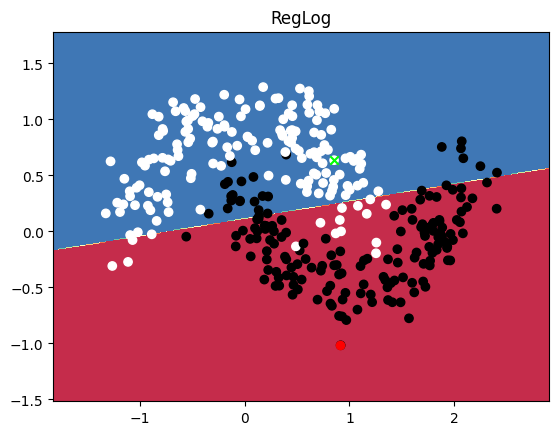

In [398]:
plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "RegLog",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[:,:2])

In [392]:
counterfactuals.cf_examples_list[0].final_cfs_df.values[:,:2]

array([[ 0.43807268, -1.01675463],
       [ 0.45182633, -1.01675463],
       [ 0.532233  , -1.01675463],
       [ 0.47617912, -1.01675463],
       [ 0.42311978, -1.01675463],
       [ 0.46515226, -1.01675463],
       [ 0.47391009, -1.01675463],
       [ 0.49839783, -1.01675463],
       [ 0.47821784, -1.01675463],
       [ 0.44885921, -1.01675463]])

In [383]:
model = res2D(2,20,1)
criterion = torch.nn.BCELoss()

grad(x_train, y_train, model, criterion, epochs=1000)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=77
query_instance = dict(zip(['x','y'], x_test[index]))
counterfactuals = explainer.generate_counterfactuals(
                    query_instance=query_instance,total_CFs=1, desired_class='opposite')
counterfactuals.visualize_as_dataframe()

/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.229192,0.49801,0.004



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.120556,-0.528136,0


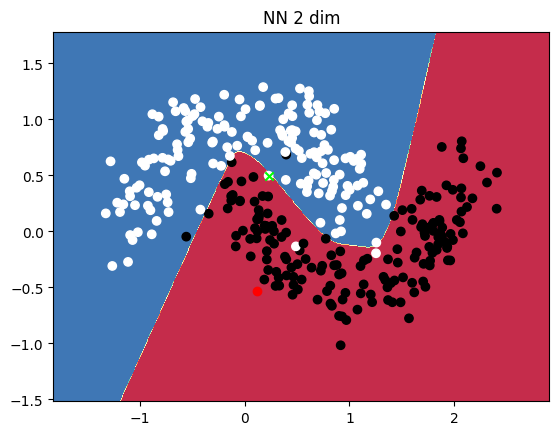

In [384]:
plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "NN 2 dim",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

In [ ]:
#proximity weight
